#From Linear classifiers to SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





PARTICIPANTS: **(Fill in your names)**
    

In [38]:
# Ioannis
import os
import numpy as np
import matplotlib.pyplot as plt

#Modules for image processing
import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

#Modules for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

#Useful for manual data splitting  
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# 1. Loading and splitting data

**a)** Download the animals10classes dataset from hippocampus, which is a subset of the Caltech 101 dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html). The animals subset is composed of images belonging to one among 10 classes. Run the code bellow to check images and labels are read correctly and store the name of the classes in the list ```labelNamesAll```

In [39]:
# Uncomment if using COLAB  (and comment next cell)
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = ('/content/drive/MyDrive/DATA/animals10classes')


In [40]:
# Uncomment if running locally (comment if running in COLAB)
IMDIR = 'C:/Users/yiann/iCloudDrive/Files/Panepistimio/Grande Ecole Centrale Nantes/Courses/Semester 1/Artificial Intelligence/Labs/Lab_2/animals10classes'

In [41]:
#Keep4students
def loadImagesAndLabels(IMDIR):
  #This function glances through all subdirectories in IMDIR, 
  #and creates a list of the subdirectory names, which will be
  #used as labels for all the images within.The function returns
  #the list of labels
  #
  #If the function returns an empty list, it is likely that IMDIR
  #is not defined correctly. In that case uncomment the lines below
  #to check the files that are actually being read.

  labelNamesAll = []

  for root, dirnames, filenames in os.walk(IMDIR):
      labelNamesAll.append(dirnames)
      #uncomment to check if the folder contains images
      #for filename in filenames:
      #   f = os.path.join(root, filename)
      #   if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
      #       print(f)

  labelNamesAll = labelNamesAll[0]
  return labelNamesAll

print(loadImagesAndLabels(IMDIR))
#Call the function and
#print the list of all labels/subdirectories
# labelNamesAll = loadImagesAndLabels(IMDIR)

['ant', 'butterfly', 'crayfish', 'crocodile', 'dragonfly', 'flamingo', 'lobster', 'octopus', 'sea_horse', 'starfish']


**b).** Use the BuildDataset function to create a reduced dataset. In this notebook we will notably deal with binary classification problems. Print the sizes of the data matrix X and the label vector Y. Print as well the retained list of labels and the content of Y.

In [42]:
#Keep4students
def buildDataset (IMDIR,labelNamesAll,K=2,N=100,imHeight=100,imWidth=100,seed=50):
    #This function builds the data matrix from (a subset) of the label list.
    #Images are read using a composition of the path and the label list.
    #Parameters of this functions are:
    # K : the number of classes to consider
    # N : the maximum number of images to read from each category (the number 
    #    of images per label is variable). 
    # imHeight,imWidth: define the size of the target image. All read images
    #                  are resized to imHeight x imWidth
    # seed : fixes the random seed to be able to reproduce the results.
    # The function returns the data matrix X and the label vector Y.
    # Ideally, the X matrix will be of size (KxN)x(ImHeight x ImWidth) but 
    # the number of rows will be less if there number of images in a given
    # category is smaller than N

    X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
    Y = -np.ones([K*N,1]) #label indices initiallized to -1
    labelNames = [] #list of retained categories

    random.seed(a=seed) #comment to make each run random

    globalCount = 0 #counts the actual number of images copied to the datamatrix

    # Iterate over the number of classes
    for i in range(K): 
        #Randomly choose a new category
        while True:
            lab = random.randint(0,len(labelNamesAll)-1)
            if lab not in labelNames:
                break

        #define the path to read the images of the chosen label.
        #folders are named after the class label, print the chosen label
        filedir = os.path.join(IMDIR,labelNamesAll[lab])
        print('The chosen label ',i, ' is ',labelNamesAll[lab])
        print('It will be read in',filedir)

        #save the name of the class in labelNames
        labelNames.append(labelNamesAll[lab])       

        #walk through the files of the label folder,
        #read images in grayscale and resize them
        #flatten the images to a vector
        #copy each image to one row of the data matrix
        #use classCount to retain at most N images per class
        #use globalCount to keep track of the total number of images 
        classCount = 0
        for filename in os.listdir(filedir):
            f = os.path.join(filedir, filename)
            if f.endswith(('.jpg')) and (classCount < N):
                image = skimage.io.imread(f, as_gray=True)
                image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
                X[globalCount,:] = image.flatten()
                Y[globalCount,:] = i
                globalCount += 1
                classCount += 1

    #Remove the unused entries of X and Y
    print("Total number of samples",globalCount)
    X = X[:globalCount,:]
    Y = Y[:globalCount,:]

    return X,Y,labelNames

In [43]:
K=2
imHeight=100
imWidth=100
N=100

#Call the buildDataset function
X, Y, labelNames =buildDataset(IMDIR, loadImagesAndLabels(IMDIR), K, N, imHeight, imWidth, seed=50)


#Check the built dataset classes
print("Used labels", labelNames)
print("Size of data matrix", X.shape)
print("Class labels", Y.T)

print("Test", X[0][:])

The chosen label  0  is  octopus
It will be read in C:/Users/yiann/iCloudDrive/Files/Panepistimio/Grande Ecole Centrale Nantes/Courses/Semester 1/Artificial Intelligence/Labs/Lab_2/animals10classes\octopus
The chosen label  1  is  dragonfly
It will be read in C:/Users/yiann/iCloudDrive/Files/Panepistimio/Grande Ecole Centrale Nantes/Courses/Semester 1/Artificial Intelligence/Labs/Lab_2/animals10classes\dragonfly
Total number of samples 103
Used labels ['octopus', 'dragonfly']
Size of data matrix (103, 10000)
Class labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]]
Test [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.18433427e-02
 6.55788695e-03 4.62583862e-05]


**c)** Split the dataset into a train (80% of samples) and a test set (20% samples) subsets.

In [44]:
#PUT your code here, and check the obtained matrices

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 1 - train_ratio, random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size= test_ratio/(test_ratio + val_ratio), random_state=42)


print("size of train dataset",X_train.shape)
print("size of val dataset",X_val.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("val target vector",Y_val.T)
print("test target vector",Y_test.T)

size of train dataset (72, 10000)
size of val dataset (15, 10000)
size of test dataset (16, 10000)
train target vector [[0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]]
val target vector [[1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1.]]
test target vector [[1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.]]


# Support Vector Machines 

**a) Linear SVM** Create an SVC model with a linear kernel and default values ``svmLin=SVC(kernel='linear')``.
 
* Fit the SVC on the training dataset and make predictions on the test set. Is it necessary to normalize the features in this case?
* Print the vector of ground truth values and the vector of predictions.
* Compute  the number of errors made.
* What is the value of the performance score in .score()?
* Activate the probability ``svmLin = SVC(kernel='linear',probability=True)``. 
* Make probabilistic predictions ``svmLin.predict_proba``
* How are these probabilities computed? (check the documentation)



In [45]:
Y_train.shape

(72, 1)

In [46]:

# Create, train and test an svm model     
svmLin = SVC(kernel='linear')
svmLin.fit(X_train, Y_train)

Y_pred = svmLin.predict(X_test)

errors = 0
for i in range(0,len(Y_test)):
    if Y_pred[i] != Y_test[i]:
        errors +=1

print(Y_test.flatten())
print(Y_pred.flatten())
print(errors)

score = svmLin.score(X_test, Y_test)
print(score)

print("PROBALISTIC SVM -------------")

# Create, train and test a "probabilistic" SVM model
svmLin = SVC(kernel='linear', probability=True)
svmLin.fit(X_train, Y_train)

Y_pred = svmLin.predict_proba(X_test)
score_proba = svmLin.score(X_test, Y_test)
print(score_proba)


[1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.]
[1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
5
0.6875
PROBALISTIC SVM -------------
0.6875


C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**b) Support vectors**
* How many parameters does the model have?
* How many hyperparameters?
* How many support vectors?
* Display some of the support vectors. Hint: use ``plt.imshow``



(59, 10000)


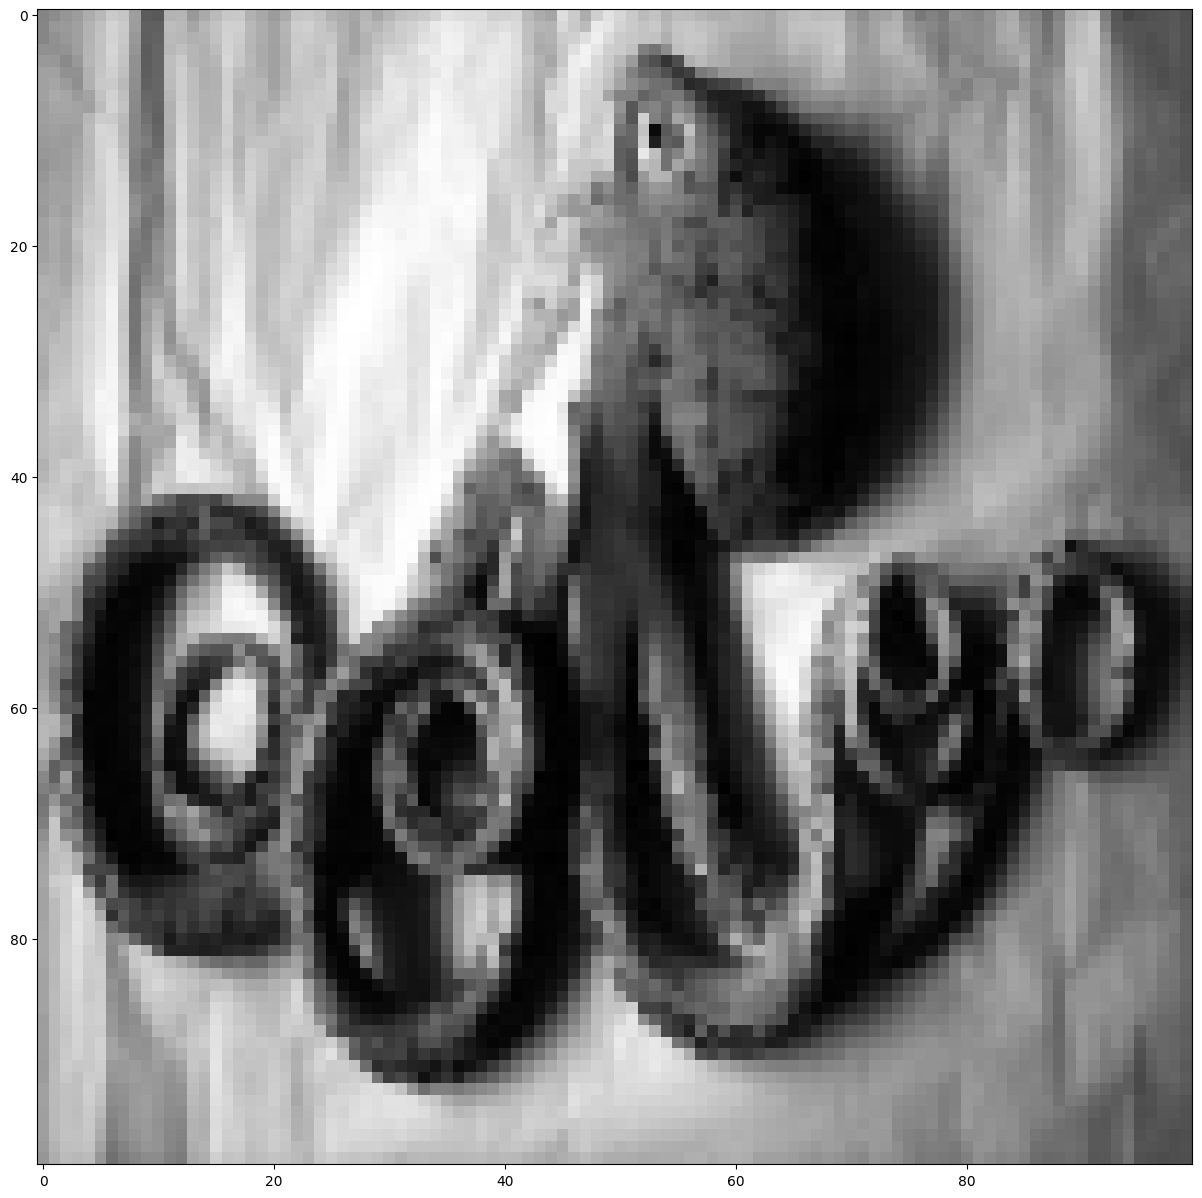

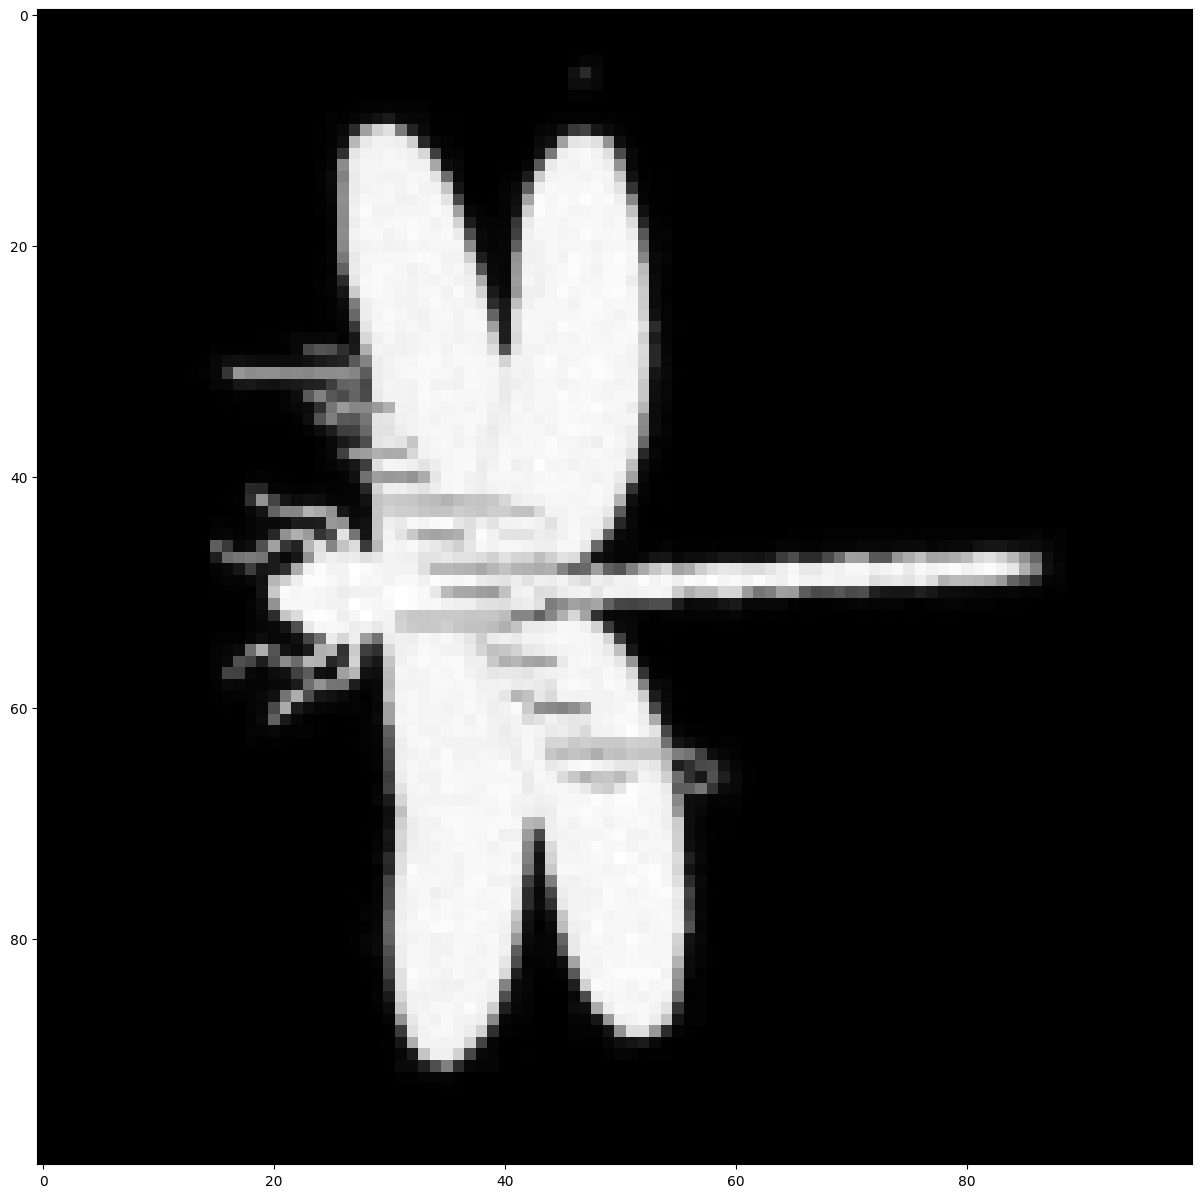

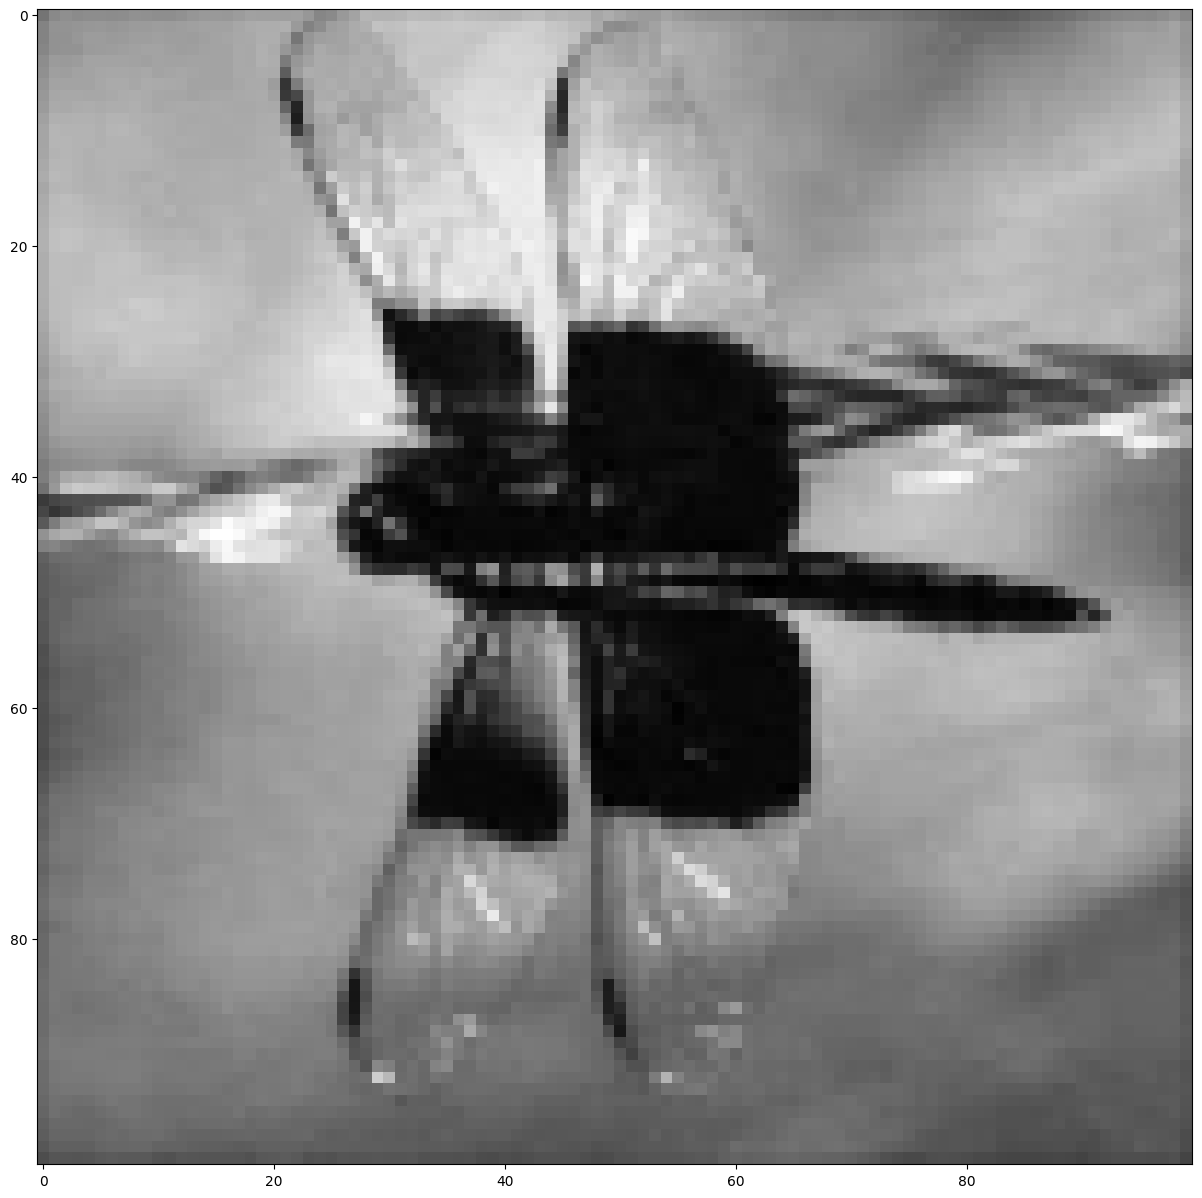

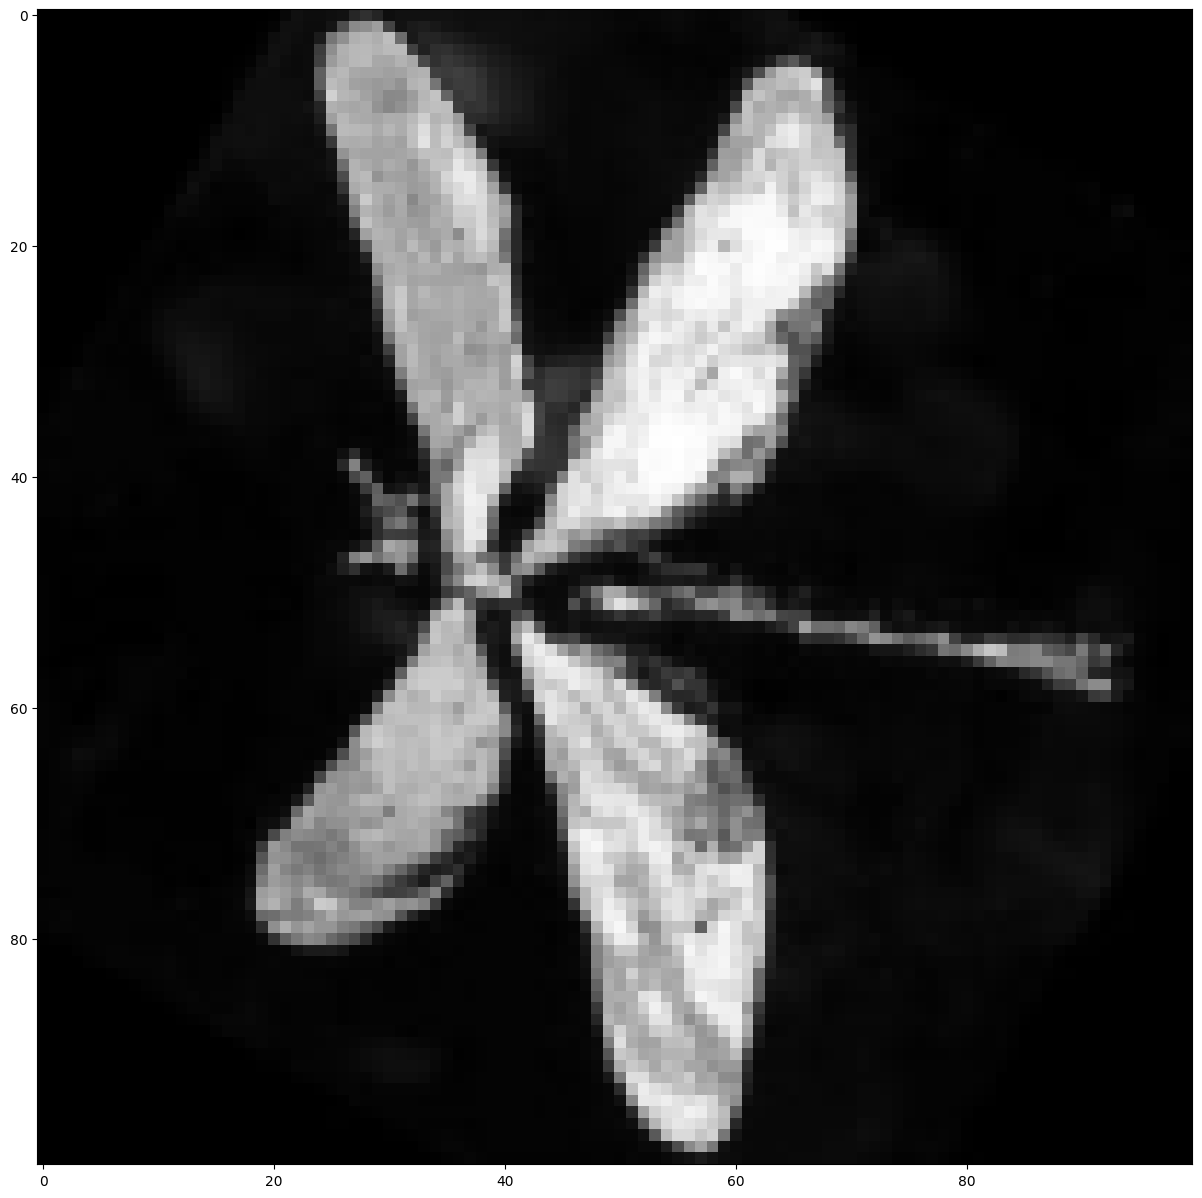

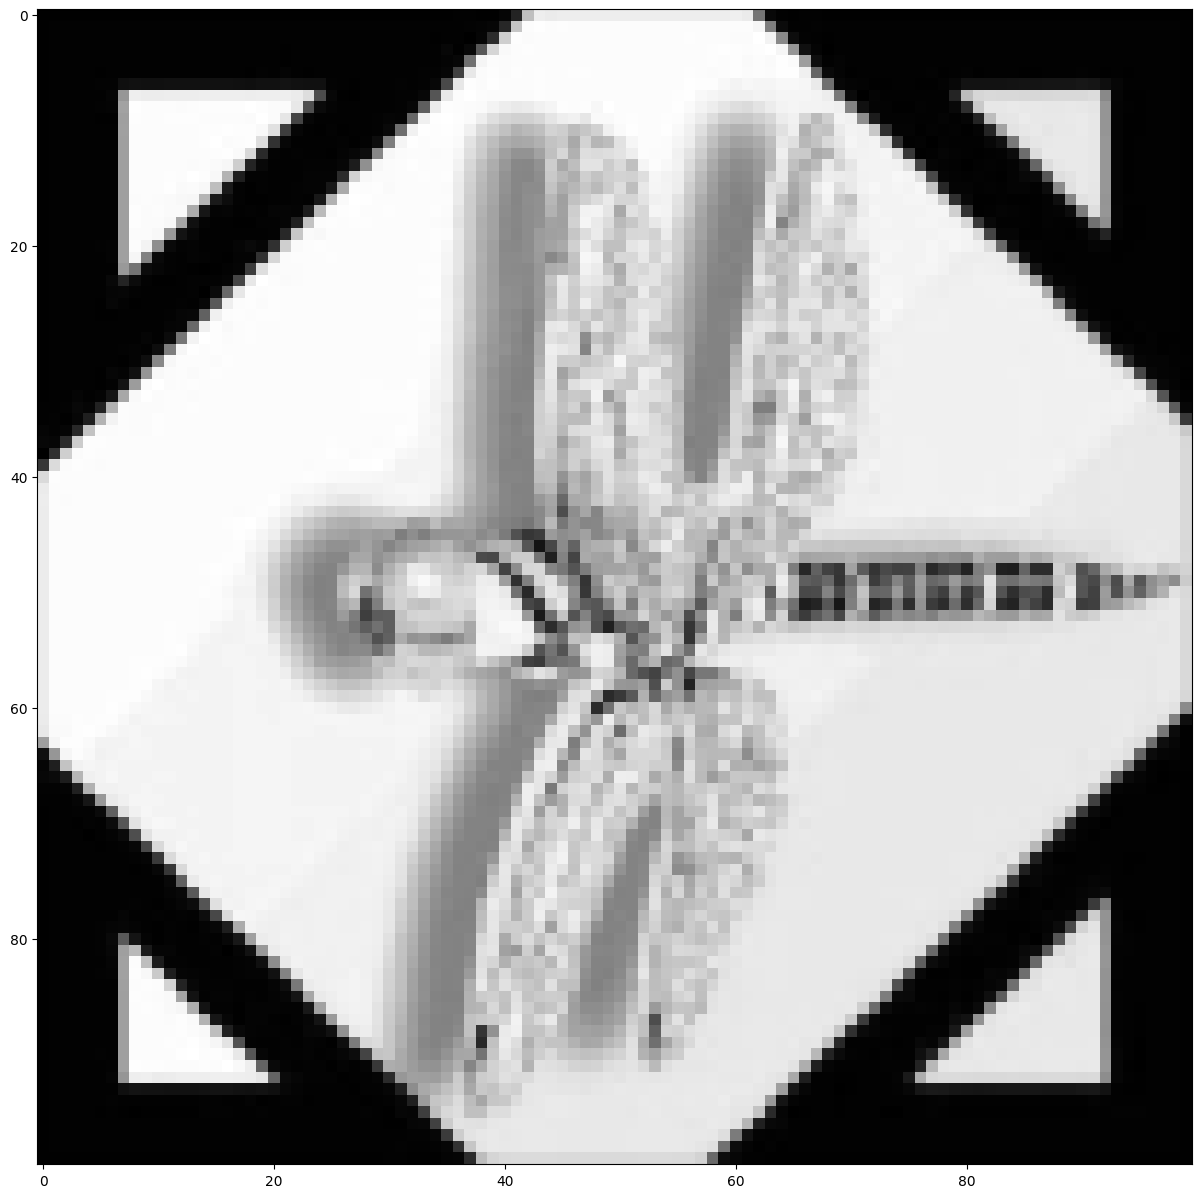

In [47]:
# The coefficient of the line need to be calculated so is a parameter 

# The gamma of kernel is a hyperparameter. We have also how much point we allow in the margin (regulazation)

supportVectors = svmLin.support_vectors_

print(supportVectors.shape)

for picture in shuffle(supportVectors)[0:5]:
    plt.figure()
    plt.imshow(picture.reshape(100,100), cmap='grey')


**c) Kernel SVMs.**
* Train three additional SVC models each using one among the kernel functions:
```
'kernel': ['rbf','poly', 'sigmoid'],
```
keep all other parameters to their default value.
* Report the number of support vectors found after fitting
* What are the hyperparameters available in each case? 
* Report the number of errors and the accuracy for each model

In [48]:
kernels = ['rbf', 'poly', 'sigmoid']

for kernel in kernels:

    svm = SVC(kernel=kernel)
    svm.fit(X_train, Y_train)

    Y_pred = svm.predict(X_test)
    score = svm.score(X_test, Y_test)
    supportVectors = svm.support_vectors_
    error = sum(prediction != truth for prediction, truth in zip(Y_pred, Y_test))
    
    print("Kernel: ", kernel)
    print("Predictions: ", Y_pred)
    print("Errors: ", errors)
    print("Score: ", score)
    print(supportVectors.shape)
    print(" ")
    





Kernel:  rbf
Predictions:  [1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Errors:  5
Score:  0.625
(70, 10000)
 
Kernel:  poly
Predictions:  [1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
Errors:  5
Score:  0.6875
(58, 10000)
 
Kernel:  sigmoid
Predictions:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
Errors:  5
Score:  0.5625
(46, 10000)
 


C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

**d)Hyperparameter tuning** 
Tune the hyperparameters of both the linear and the non-linear SVMs using the validation set. Alternatively use the ``GridSearchCV`` functionality from sklearn

In [49]:
# Some values for reference, you might change this for improved results
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'degree': [2, 3, 5 , 7, 9]}

kernels = ['linear','rbf', 'poly', 'sigmoid']

for kernel in kernels:

    svm = SVC(kernel=kernel)

    svm = GridSearchCV(svm, param_grid)
    svm.fit(X_val, Y_val.flatten())

    Y_pred = svm.predict(X_test)
    score = svm.score(X_test, Y_test)

    print("Kernel: ", kernel)
    print("Best Parameters: ", svm.best_params_)
    print("Predictions: ", Y_pred)
    print("Score: ", score)
    print(" ")
    



C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Kernel:  linear
Best Parameters:  {'C': 0.1, 'degree': 2, 'gamma': 1}
Predictions:  [1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.]
Score:  0.625
 


C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Kernel:  rbf
Best Parameters:  {'C': 100, 'degree': 2, 'gamma': 0.0001}
Predictions:  [1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
Score:  0.8125
 


C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Kernel:  poly
Best Parameters:  {'C': 0.001, 'degree': 2, 'gamma': 0.001}
Predictions:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Score:  0.5
 


C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Kernel:  sigmoid
Best Parameters:  {'C': 0.001, 'degree': 2, 'gamma': 1}
Predictions:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Score:  0.5
 


## 2. PERFORMANCE MEASURES
**a) Fill in the function bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix values TP, TN, FP, FN

You can use the code bellow or use your own

**Hint:** Add a numerical zero eps to the denominators to prevent dividing by zero

Compare your results vs the in-built sklearn measures:
```from sklearn.metrics import classification_report```

In [50]:
# Functions to compute the errors between prediction and ground truth 
from sklearn.metrics import classification_report

def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_gt)
    
    eps = 1e-12    

    # True positives TP
    TP = sum((predicted == 1) and (actual == 1) for predicted, actual in zip(Y_pred, Y_gt))

    # True negatives TN
    TN = sum((predicted == 0) and (actual == 0) for predicted, actual in zip(Y_pred, Y_gt))
    
    # False positives FP
    FP = sum((predicted == 1) and (actual == 0) for predicted, actual in zip(Y_pred, Y_gt))
        
    # False negatives FN
    FN = sum((predicted == 0) and (actual == 1) for predicted, actual in zip(Y_pred, Y_gt))

    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN
    
    
    # Accuracy
    measures['accuracy'] = (TP + TN) / (TP + TN + FP + FN + eps)
    
    # Precision
    measures['precision'] = TP / (TP + FP + eps)
        
    # Specificity
    measures['specificity']= TN / (TN + FP + eps)
    
    # Recall
    measures['recall'] = TP / (TP + FN + eps)
    
    # F-measure
    measures['f1'] = (2*TP + TN) / (2*TP + TN + FP + FN + eps)
    
    # Negative Predictive Value
    measures['npv'] = TN / (TN + FN + eps)
    
    # False Predictive Value
    measures['fpr'] =  FP / (FP + TN + eps)
    
    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n')
    
    return measures

compute_measures(Y_test, Y_pred)

target_names = ['Octopus', 'Dragonfly']
rep = classification_report(Y_test, Y_pred)
print(rep)

TP  [8] TN  0 FP [8] FN 0 Total [16]
Accuracy  [0.5] 
 Precision [0.5] 
 Recall [1.] 
 Specificity  [0.] 
 F-measure [0.66666667] 
 NPV 0.0 
 FPV [1.] 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

**b) ROC curves** 
- Plot the ROC curves of all the trained svm models (with different kernels including linear) before and after the hyperparameter tuning. Comment the results
- Compare the roc curves of the best obtained models for each kernel between. Also add a curve for a  logistic regression model. 

You might use your own thresholding function or use the ``roc_curve`` functionality from scikit learn

Hint: To threshold we need to make probabilistic predictions

C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\yiann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-

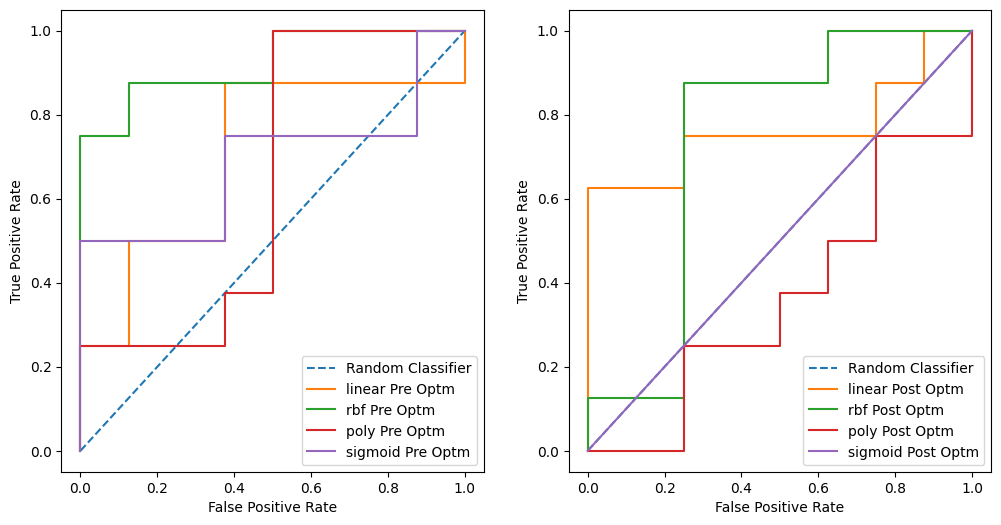

In [56]:
from sklearn.metrics import roc_curve, RocCurveDisplay
kernels = ['linear','rbf', 'poly', 'sigmoid']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

for kernel in kernels:
    
    #before hyperparameter tuning:
    svm = SVC(kernel=kernel, probability=True)
    svm.fit(X_train,Y_train.flatten())
    Y_pred = svm.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(Y_test, Y_pred[:,1])#[:,1]
    
    axes[0].plot(fpr,tpr, label = kernel + " Pre Optm");
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()   
    
    
    #after hyperparameter tunning:
    svm = GridSearchCV(svm, param_grid)
    svm.fit(X_val,Y_val.flatten())
    Y_pred = svm.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(Y_test, Y_pred[:,1])#[:,1]
    
    axes[1].plot(fpr,tpr, label = kernel + " Post Optm");
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()   
   

plt.show()
# Logistic Regression

**c) Qualitative Results** Using your best model, show some of the test images and write on the title the predictions vs the ground truth labels 

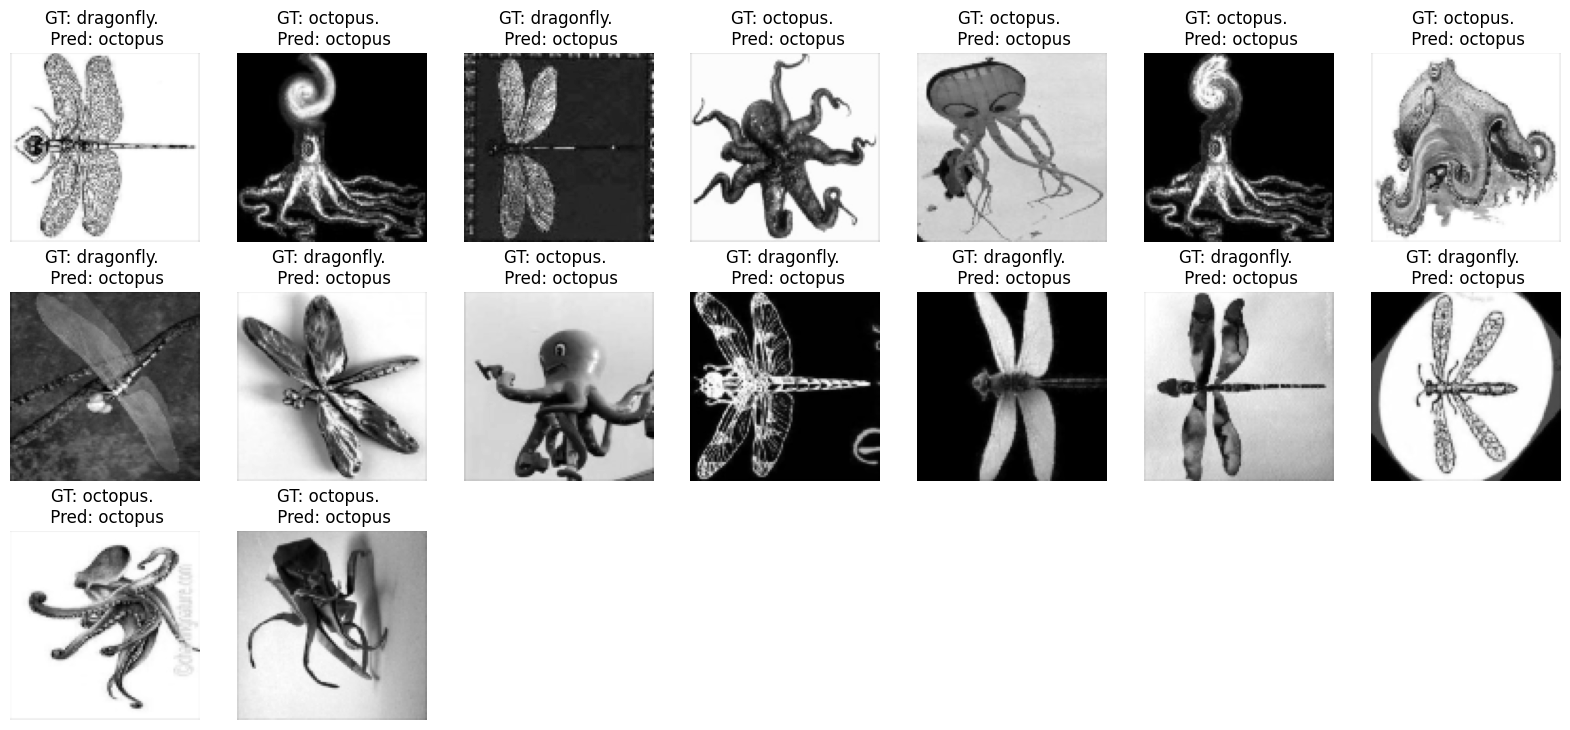

In [55]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]

#Change your predictions vector here
Y_best=Y_pred

fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth)) 

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_best.ravel()[i].astype(int)] 
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()
